# TPS Estimator

Estimating Transactions Per Second (TPS) is a common requirement in designing API integrations. The factors affecting how many TPS is generated for a given API are number of users, traffic pattern and caching time used by the client. 

My main challenge with estimating TPS is the accuracy of extrapolating present TPS to a different number of users or different caching times. This notebook allows to simulate variety of different traffic patterns to estimate TPS when one of the parameters changes.

In [3]:
import numpy as np
import pandas as pd
import random
import string

## Setup

First, we want to build a realistic model of the existing API traffic. Broadly there are two types of API requests: user-generated and background traffic. For the purpose of TPS estimation I am mainly intersted in user-generated traffic. When simulating user-generated traffic, we are looking at these parameters:

- number of users
- how many peaks of traffic do we have per day
- how wide are the peaks (how steep is the increase / decrease in amount of requests)

*TODO: Create dummy data plot generated by X users with peaks / peak width. Users are not unique here*}

Let's first create dummy data with random amount of records per user:

<AxesSubplot:>

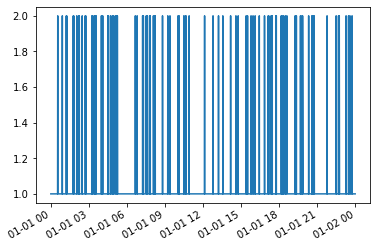

In [4]:
userid_length = 10
number_of_users = 10
number_of_records_per_user = 1000

def get_userid():
    return ''.join(random.choices(string.digits, k=userid_length))

def create_user_record():
    user_records = []
    
    record_count = np.random.randint(1, number_of_records_per_user, size=1)[0]
    
    ts = pd.date_range(start='2022-01-01', end='2022-01-02', freq='S')
    user_ts = pd.to_datetime(np.sort(np.random.choice(ts, size=record_count)))

    user_id = get_userid()
    for i in range(record_count):
       user_records.append((user_ts[i], user_id)) 
    
    return user_records

def create_records(number_of_users, create_user_function):
    records = []
    for i in range(number_of_users):
        user_records = create_user_function()
        for record in user_records:
            records.append(record)

    df = pd.DataFrame(
        records, 
        columns=['ts', 'userid']
    )
    df = df.sort_values('ts')
    
    return df

df = create_records(number_of_users, create_user_record)
df['ts'].value_counts().plot()

Now let's create records based on normal distribution instead of uniform random

<AxesSubplot:>

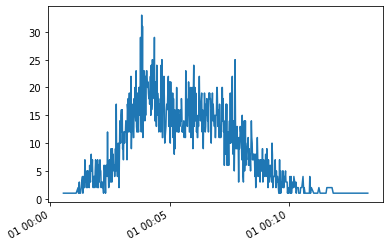

In [5]:
def create_user_record_normal():
    user_records = []
    
    record_count = np.random.randint(1, number_of_records_per_user, size=1)[0]
    
    # Come up with a better mu and sigma calculation
    mu, sigma = record_count / 2, record_count / 10
    indexes = np.rint(
        np.random.normal(mu, sigma, record_count)
    )
    
    ts = pd.date_range(start='2022-01-01', end='2022-01-02', freq='S')
    user_ts = pd.to_datetime(np.sort(
        [ts[int(index)] for index in indexes]
    ))

    user_id = get_userid()
    for i in range(record_count):
       user_records.append((user_ts[i], user_id)) 
    
    return user_records

df = create_records(number_of_users, create_user_record_normal)
df['ts'].value_counts().plot()

One normal distribution would have only one mean. User generated API traffic can have two peaks during the day: around the midday and then towards the evening. Let's use two different normal distributions to simulate this process.

<AxesSubplot:>

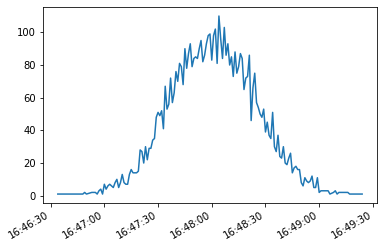

In [18]:
def create_user_record_normal_v2():
    user_records = []
    
    record_count = np.random.randint(1, number_of_records_per_user, size=1)[0]
        
    ts = pd.date_range(start='2022-01-01', end='2022-01-02', freq='S')

    # Midday indixes
    mu, sigma = len(ts) / 2.0, len(ts) / 3600
    midday_indexes = np.rint(
        np.random.normal(mu, sigma, record_count)
    )
    
    # Evening indixes
    mu, sigma = len(ts) / 5.0, len(ts) / 36000
    evening_indexes = np.rint(
        np.random.normal(mu, sigma, record_count)
    )  
    
    indexes = midday_indexes + evening_indexes
    user_ts = pd.to_datetime(np.sort(
        [ts[int(index)] for index in indexes]
    ))

    user_id = get_userid()
    for i in range(record_count):
       user_records.append((user_ts[i], user_id)) 
    
    return user_records

df = create_records(number_of_users, create_user_record_normal_v2)
df['ts'].value_counts().plot()

## Introducing caching

We now make an assumption that users calling the API are not unique and that caching can substantially reduce API load. Let's see what happens to the TPS as we increase and decrease caching times

In [2]:
# TPS plots for different caching times

Now let's see what happens when a percentage of API calls is using a different caching time

In [4]:
# TPS plots with % of caching times

## Change amount users

Now let's have more users calling the API and see what happens with the TPS to various caching times

In [5]:
# TPS plots vs amount of users vs caching time

## Change pattern in user behavior

Now let's change the actual distribution of users within a dataset. Let's have some of the users call the API very frequently and other less so

In [6]:
# TPS plots for different user behaviors